




















## Que es la neumonia
La neumonía es una infección que afecta un pulmón o los dos. Hace que los sacos de aire, o alvéolos, de los pulmones se llenen de líquido o pus. Hay bacterias, virus u hongos que pueden provocar neumonía.
La neumonía suele ser causada por una infección por virus o bacterias y, con menos frecuencia, por otros microorganismos, ciertos medicamentos o afecciones como las enfermedades autoinmunes. Los factores de riesgo incluyen fibrosis quística, enfermedad pulmonar obstructiva crónica (EPOC), asma, diabetes, insuficiencia cardíaca, antecedentes de tabaquismo, poca capacidad para toser, como después de un accidente cerebrovascular y un sistema inmunitario débil. El diagnóstico a menudo se basa en los síntomas y el examen físico. La radiografía de tórax, los análisis de sangre y el cultivo del esputo pueden ayudar a confirmar el diagnóstico. La enfermedad se puede clasificar según el lugar donde se adquirió, como neumonía adquirida en la comunidad o en el hospital o asociada a la atención médica.


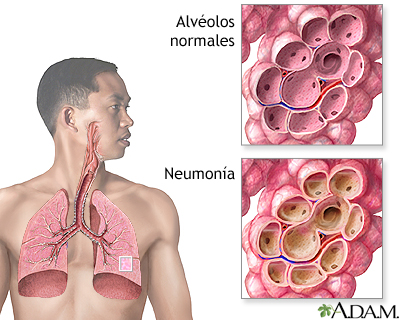



## Entendiendo el problema

como queremos hacer un detector de una enfermedad, en este caso la neumonía, tenemos que usar una red neuronal convolucional, ya que estas nos permiten la clasificación de imágenes. ¿Por qué esto es relevante? Es relevante porque para entrenar este modelo utilizaremos radiografías de rayos X que ya están clasificadas en imágenes con neumonía y sin neumonía. Para hacer este modelo usaremos TensorFlow, ya que es fácil de usar y tiene su API Keras.


## Conociendo nuestros datos

Para este proyecto hemos utilizado el dataset Chest X-Ray Images (Pneumonia).

Estos datos son Conjunto de datos de imágenes validadas de OCT y radiografía de tórax descritas y analizadas en "Clasificación y derivación basadas en el aprendizaje profundo de enfermedades humanas tratables". Las imágenes OCT se dividen en un conjunto de entrenamiento y un conjunto de pruebas de pacientes independientes. 


### Como esta organizado el dataset

El conjunto de datos está organizado en 3 carpetas (train, test, val) y contiene subcarpetas para cada categoría de imagen (Neumonía/Normal). Hay 5.863 imágenes de rayos X (JPEG) y 2 categorías (neumonía/normal). 

Se seleccionaron imágenes de radiografía de tórax (antero-posterior) de cohortes retrospectivas de pacientes pediátricos de uno a cinco años de edad del Centro Médico de Mujeres y Niños de Guangzhou, Guangzhou. Todas las radiografías de tórax se realizaron como parte de la atención clínica de rutina de los pacientes. 

Para el análisis de las imágenes radiográficas de tórax, todas las radiografías de tórax se examinaron inicialmente para el control de calidad mediante la eliminación de todas las exploraciones de baja calidad o ilegibles. Los diagnósticos de las imágenes fueron calificados por dos médicos expertos antes de ser autorizados para entrenar el sistema de IA. Con el fin de tener en cuenta los posibles errores de calificación, el conjunto de evaluación también fue revisado por un tercer experto.


## Area de importacion

In [4]:
import numpy as np
import pandas as pd 

import os
for dirname, _, filenames in os.walk('/chest_xray-neumonia/'):
    for filename in filenames:
        print(os.path.join(dirname, filename))



## importamos las librerias necesarias

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator  #aqui realize cambio de importacion 
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from keras.callbacks import ReduceLROnPlateau
from tqdm import tqdm
import cv2
import os




## Descripcion del dataSet utilizado ( )

In [7]:
def get_training_data(data_dir):
    data = [] 
    for label in ['PNEUMONIA', 'NORMAL']: 
        path = os.path.join(data_dir, label)
        class_num = 1 if label == 'PNEUMONIA' else 0
        for img in tqdm(os.listdir(path)):
            try:
                if not img.endswith('.DS_Store'): # Skip non-image files
                    img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                    resized_arr = cv2.resize(img_arr, (150, 150)) # Resize image to (150, 150)
                    data.append([resized_arr, class_num])
            except Exception as e:
                print(f"Error processing {os.path.join(path, img)}: {str(e)}")
    return np.array(data, dtype=object) # Specify dtype as object

## Visualizacion de los datos y pre procesamiento

In [8]:
train = get_training_data('chest_xray-neumonia/chest_xray/train')
test = get_training_data('chest_xray-neumonia/chest_xray/test')
val = get_training_data('chest_xray-neumonia/chest_xray/val')

100%|██████████| 9/9 [00:00<00:00, 44.23it/s]


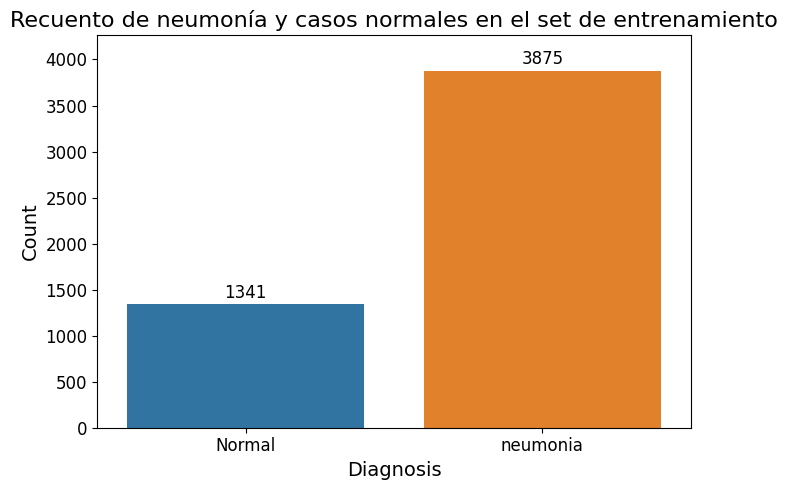

In [80]:
# Contar las instancias de cada clase
unique, counts = np.unique([item[1] for item in train], return_counts=True)

# Crear un DataFrame con los conteos
df = pd.DataFrame({'Diagnosis': ['Normal', 'neumonia'], 'count': counts})

# Crear el gráfico
plt.figure(figsize=(7, 5))
ax = sns.barplot(x='Diagnosis', y='count', data=df, hue='Diagnosis', palette=['#1f77b4', '#ff7f0e'], legend=False)

# Personalizar el gráfico
plt.title('Recuento de neumonía y casos normales en el set de entrenamiento', fontsize=16)
plt.xlabel('Diagnosis', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.tick_params(axis='both', which='major', labelsize=12)

# Añadir los valores en las barras
for i, v in enumerate(df['count']):
    ax.text(i, v + 30, str(v), ha='center', va='bottom', fontsize=12)

# Ajustar los límites del eje y
plt.ylim(0, max(df['count']) * 1.1)

# Mostrar el gráfico
plt.tight_layout()
plt.show()

Los datos parecen desequilibrados. Para aumentar el no. de ejemplos de entrenamiento, usaremos el aumento de datos - Vista previa de las imágenes de ambas clases.



Vista previa de las imágenes de ambas clases.

Text(0.5, 1.0, 'NORMAL')

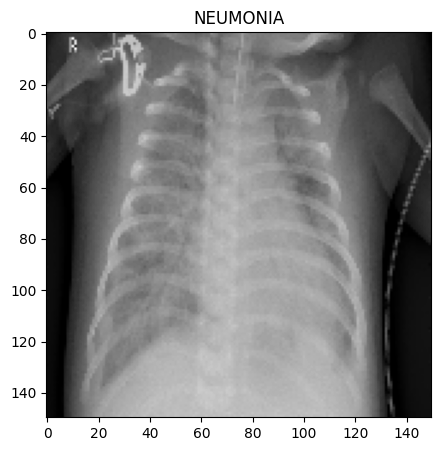

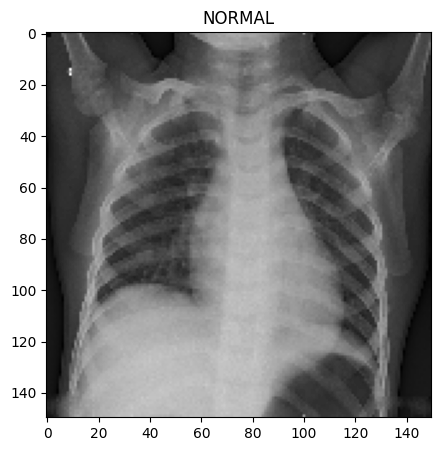

In [81]:
labels = {0: 'NORMAL', 1: 'NEUMONIA'}

plt.figure(figsize = (5,5))
plt.imshow(train[0][0], cmap='gray')
plt.title(labels[train[0][1]])

plt.figure(figsize = (5,5))
plt.imshow(train[-1][0], cmap='gray')
plt.title(labels[train[-1][1]])

In [25]:
x_train = []
y_train = []

x_val = []
y_val = []

x_test = []
y_test = []

for feature, label in train:
    x_train.append(feature)
    y_train.append(label)

for feature, label in test:
    x_test.append(feature)
    y_test.append(label)
    
for feature, label in val:
    x_val.append(feature)
    y_val.append(label)

In [26]:
# Normalize the data
x_train = np.array(x_train) / 255
x_val = np.array(x_val) / 255
x_test = np.array(x_test) / 255

In [27]:
# resize data for deep learning 
img_size = 150  # Assuming your desired image size is 150x150
x_train = x_train.reshape(-1, img_size, img_size, 1)
y_train = np.array(y_train)

x_val = x_val.reshape(-1, img_size, img_size, 1)
y_val = np.array(y_val)

x_test = x_test.reshape(-1, img_size, img_size, 1)
y_test = np.array(y_test)

## Aumento de datos
Para evitar el problema de sobreajuste, necesitamos expandir artificialmente nuestro conjunto de datos. Podemos hacer que su conjunto de datos existente sea aún más grande. La idea es alterar los datos de entrenamiento con pequeñas transformaciones para reproducir las variaciones. Los enfoques que alteran los datos de entrenamiento de manera que cambian la representación de la matriz mientras se mantiene la misma etiqueta se conocen como técnicas de aumento de datos. Algunos aumentos populares que la gente usa son escalas de grises, volteos horizontales, volteos verticales, recortes aleatorios, fluctuaciones de color, traslaciones, rotaciones y mucho más. Al aplicar solo un par de estas transformaciones a nuestros datos de entrenamiento, podemos duplicar o triplicar fácilmente el número de ejemplos de entrenamiento y crear un modelo muy sólido.

In [28]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range = 30,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.2, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip = True,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(x_train)

For the data augmentation, i choosed to :

Randomly rotate some training images by 30 degrees
Randomly Zoom by 20% some training images
Randomly shift images horizontally by 10% of the width
Randomly shift images vertically by 10% of the height
Randomly flip images horizontally. Once our model is ready, we fit the training dataset.

In [31]:
# Define the input shape
input_shape = (150, 150, 1)

model = Sequential()
model.add(keras.Input(shape=input_shape))  # Define input layer

model.add(Conv2D(32 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu' , input_shape = (150,150,1)))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.1))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(128 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(256 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Flatten())
model.add(Dense(units = 128 , activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(units = 1 , activation = 'sigmoid'))
model.compile(optimizer = "rmsprop" , loss = 'binary_crossentropy' , metrics = ['accuracy'])
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_10 (Conv2D)              │ (None, 150, 150, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 150, 150, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 75, 75, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 75, 75, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 75, 75, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 75, 75, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 38, 38, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 38, 38, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 38, 38, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 19, 19, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 19, 19, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 19, 19, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 19, 19, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 10, 10, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 10, 10, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 10, 10, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 10, 10, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 5, 5, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 6400)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │       819,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴─────────────

 Total params: 1,246,401 (4.75 MB)

 Trainable params: 1,245,313 (4.75 MB)

 Non-trainable params: 1,088 (4.25 KB)

In [36]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1,factor=0.3, min_lr=0.000001)

In [37]:
history = model.fit(datagen.flow(x_train, y_train, batch_size=32),
                    epochs=12,
                    validation_data=datagen.flow(x_val, y_val, batch_size=32),
                    callbacks=[learning_rate_reduction])

Epoch 1/12
163/163 ━━━━━━━━━━━━━━━━━━━━ 181s 1s/step - accuracy: 0.8349 - loss: 0.3994 - val_accuracy: 0.5000 - val_loss: 54.8533 - learning_rate: 0.0010
Epoch 2/12
163/163 ━━━━━━━━━━━━━━━━━━━━ 171s 1s/step - accuracy: 0.8854 - loss: 0.2738 - val_accuracy: 0.5000 - val_loss: 41.2867 - learning_rate: 0.0010
Epoch 3/12
163/163 ━━━━━━━━━━━━━━━━━━━━ 173s 1s/step - accuracy: 0.9053 - loss: 0.2323 - val_accuracy: 0.6875 - val_loss: 2.3692 - learning_rate: 0.0010
Epoch 4/12
163/163 ━━━━━━━━━━━━━━━━━━━━ 159s 971ms/step - accuracy: 0.9292 - loss: 0.2037 - val_accuracy: 0.5000 - val_loss: 2.7988 - learning_rate: 0.0010
Epoch 5/12
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 968ms/step - accuracy: 0.9430 - loss: 0.1696
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
163/163 ━━━━━━━━━━━━━━━━━━━━ 159s 969ms/step - accuracy: 0.9430 - loss: 0.1696 - val_accuracy: 0.6250 - val_loss: 1.2785 - learning_rate: 0.0010
Epoch 6/12
163/163 ━━━━━━━━━━━━━━━━━━━━ 158s 967ms/step - accuracy: 0.9578

In [38]:
print("La perdida del modelo es - " , model.evaluate(x_test,y_test)[0])
print("La precisión del modelo es - " , model.evaluate(x_test,y_test)[1]*100 , "%")

20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 156ms/step - accuracy: 0.9271 - loss: 0.1940
La perdida del modelo es -  0.2517297565937042
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 159ms/step - accuracy: 0.9271 - loss: 0.1940
La precisión del modelo es -  91.02563858032227 %


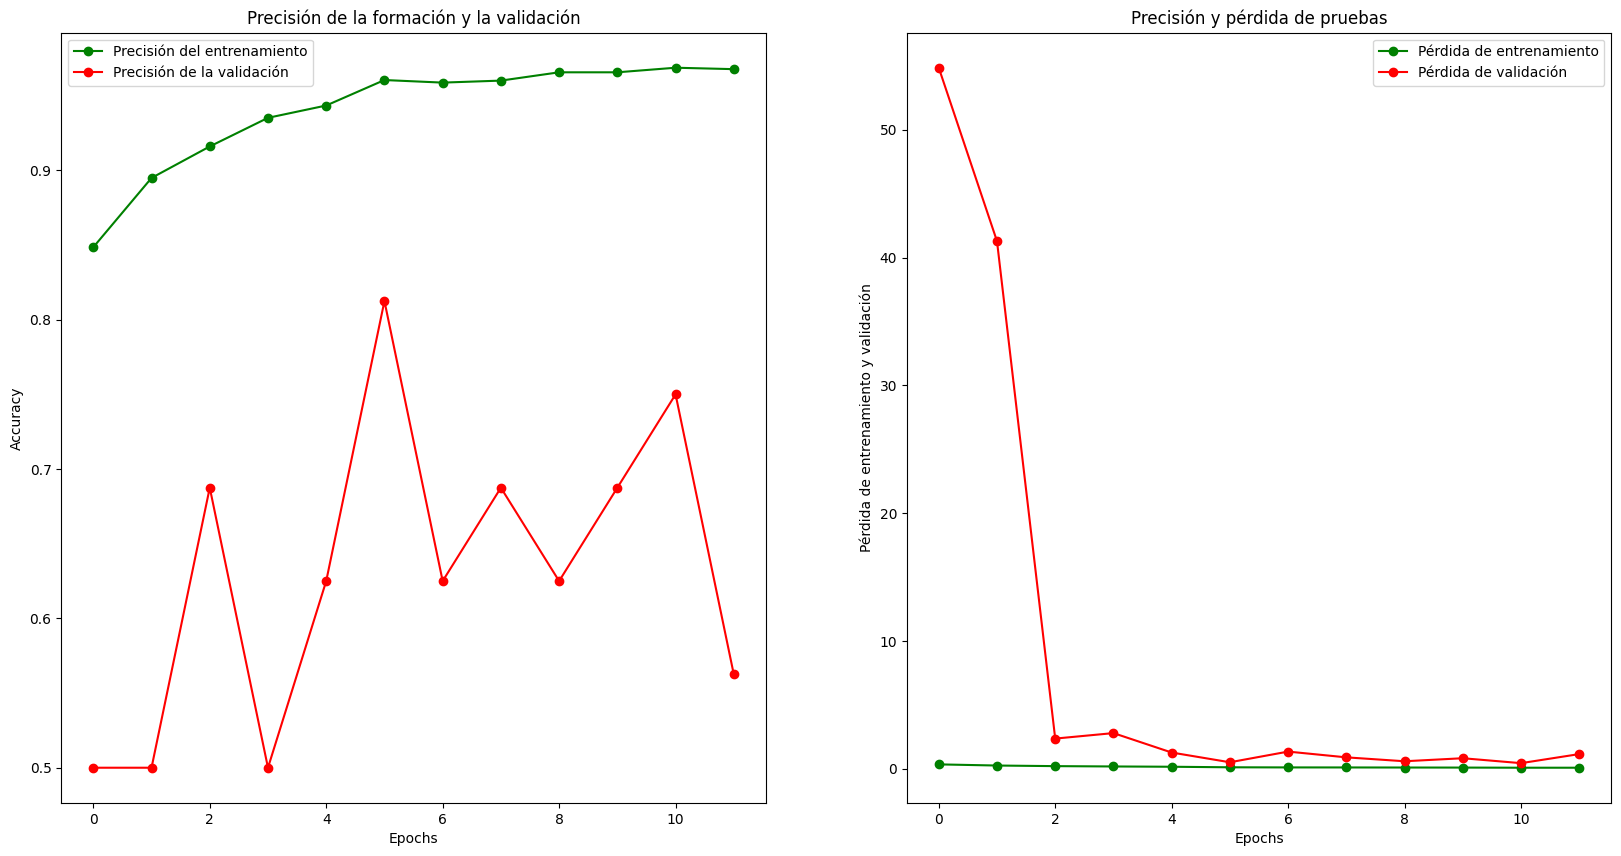

In [85]:
epochs = [i for i in range(12)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
fig.set_size_inches(20,10)

ax[0].plot(epochs , train_acc , 'go-' , label = 'Precisión del entrenamiento')
ax[0].plot(epochs , val_acc , 'ro-' , label = 'Precisión de la validación')
ax[0].set_title('Precisión de la formación y la validación')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'g-o' , label = 'Pérdida de entrenamiento')
ax[1].plot(epochs , val_loss , 'r-o' , label = 'Pérdida de validación')
ax[1].set_title('Precisión y pérdida de pruebas')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Pérdida de entrenamiento y validación")
plt.show()

In [50]:
predictions = model.predict(x_test)  # Get class probabilities
predictions = predictions.reshape(1,-1)[0] # Get predicted class labels

# Print the first 15 predictions
predictions[:15]

20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 154ms/step


array([0.9078017 , 0.97628635, 0.9999883 , 1.        , 0.9999643 ,
       1.        , 0.99973965, 0.99999994, 0.39323983, 0.9989285 ,
       0.9999987 , 0.6875185 , 0.99998444, 0.99392474, 0.9554244 ],
      dtype=float32)

In [86]:
print(classification_report(y_test, predictions, target_names = ['Pneumonia (Class 0)','Normal (Class 1)']))

                     precision    recall  f1-score   support

Pneumonia (Class 0)       0.90      0.86      0.88       234
   Normal (Class 1)       0.92      0.94      0.93       390

           accuracy                           0.91       624
          macro avg       0.91      0.90      0.90       624
       weighted avg       0.91      0.91      0.91       624



In [91]:
# Convertir probabilidades a etiquetas de clase
predictions_classes = (predictions > 0.5).astype(int)

# Ahora usa predictions_classes en lugar de predictions
cm = confusion_matrix( y_test, predictions_classes)
print(cm)

[[201  33]
 [ 23 367]]


In [52]:
cm = pd.DataFrame(cm , index = ['0','1'] , columns = ['0','1'])

<Axes: >

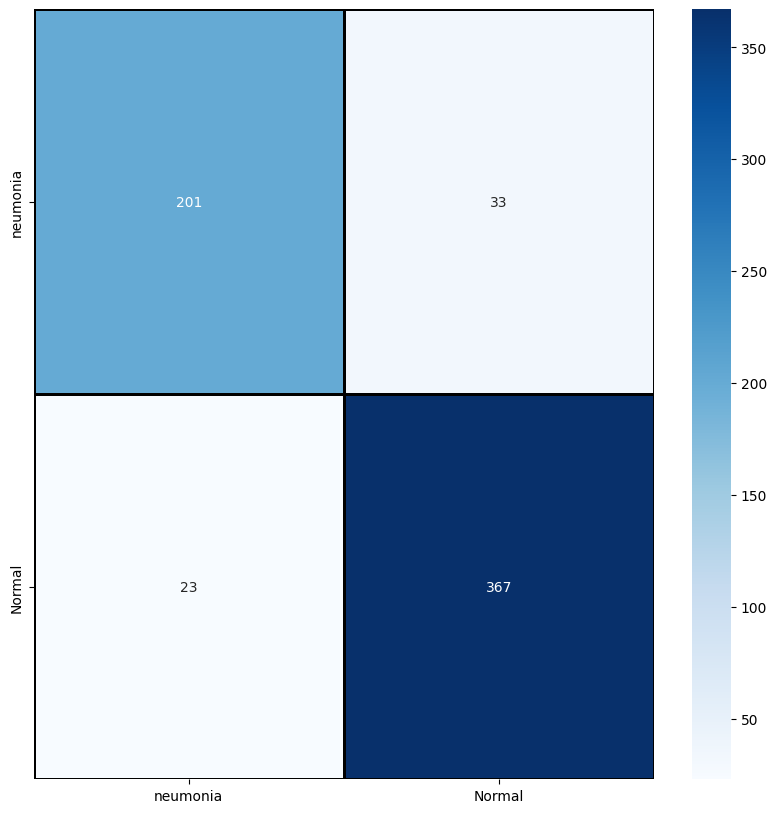

In [84]:
plt.figure(figsize = (10,10))
sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='',xticklabels = labels,yticklabels = labels)

In [54]:
correct = np.nonzero(predictions == y_test)[0]
incorrect = np.nonzero(predictions != y_test)[0]

Algunas de las clases predichas correctamente

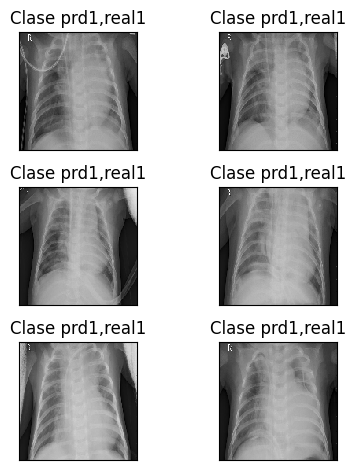

In [72]:
i = 0
predictions = (predictions > 0.5).astype(int)
for c in correct[:6]:
    plt.subplot(3,2,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(x_test[c].reshape(150,150), cmap="gray", interpolation='none')
    plt.title("Clase prd{},real{}".format(predictions[c], y_test[c]))
    plt.tight_layout()
    i += 1

Algunas de las clases predichas incorrectamente

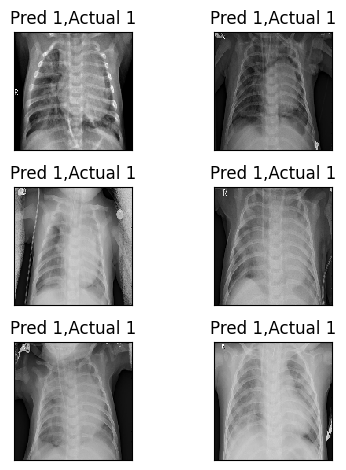

In [73]:
i = 0
predictions = (predictions > 0.5).astype(int)
for c in incorrect[:6]:
    plt.subplot(3,2,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(x_test[c].reshape(150,150), cmap="gray", interpolation='none')
    plt.title("Pred {},Actual {}".format(predictions[c], y_test[c]))
    plt.tight_layout()
    i += 1